## Using this notebook 

Using dataframes for both inside and outside the cedar and witch fires, compare the shrub cover change. 

### Step 0: Store variables
### Step 1: Libraries
- Import required libraries.
### Step 2: Build geometry and dataframes
- Create single polygons of the fires (inside) and the buffer (outside) to compare the shrub cover differences between burned and unburned areas.
- Create gdfs for the fire and outside ring to use in the array.
- Plot the two buffers to ensure they look correct.
### Step 3: Clip the raster
- Create a helper function for clipping
- Call the years needed for Cedar and Witch 
- **Do not** call all the .tif files or we will overload RAM
- Create a cedar shrub df and a withc shrub df for our inside and outside comparison
### Step 4: Pivot tables
- Create two pivot tables to see what the mean differences are between the inside-outside for both fires
### Step 5: Plot 
- Create figures for both cedar and witch
- One set of figures plotting the shrub difference over time inside and outside, and inside minus outside
- One set of visualized maps to see the inside and outside differences
- **Due to how long these take to plot, save the figure when plotting**
### Step 6: Store variables

### Step 0: Store variables

In [1]:
%store -r

### Step 1: Libraries

In [ ]:
# libraries, directories, CRS

import geopandas as gpd
import rasterio
from rasterio import mask
import numpy as np
import pandas as pd
from pathlib import Path
import re
import matplotlib.pyplot as plt
import rioxarray as rxr
import xarray as xr

# Project root & data dirs (same as Cedar)
PROJECT_ROOT = Path("C:/Users/kayle/Desktop/earth-analytics/Final project/ramona-fire-recovery")
DATA_DIR = PROJECT_ROOT / "data"
BOUNDARY_DIR = DATA_DIR / "boundaries"
RAW_LANDCOVER_DIR = DATA_DIR / "raw" / "landcover"
FIG_DIR = Path(r"C:\Users\kayle\Desktop\earth-analytics\Final project\ramona-fire-recovery\figures\landcover")
FIG_DIR.mkdir(parents=True, exist_ok=True)

# RCMAP shrub directory (already filled from Cedar notebook work)
RCMAP_SHRUB_DIR = RAW_LANDCOVER_DIR / "rcmap_shrub"

# Target CRS (same as Cedar)
target_crs = "EPSG:3310"

target_crs, RCMAP_SHRUB_DIR

('EPSG:3310',
 WindowsPath('C:/Users/kayle/Desktop/earth-analytics/Final project/ramona-fire-recovery/data/raw/landcover/rcmap_shrub'))

### Step 2: Create fire geodataframes
Here we need different sets of gdfs to do our inside and outside comparison of the fire perimeters. We will create a single polygon both for inside and outside the fire perimeters (cedar_geom v. cedar_ring_geom). We will then also create one for our buffer area (0-4km) beyond the perimeter of the fires. Once we have all our geometries set, we can build out the gdf for our arrays for cedar and witch where we will have a gdf for the fire and one for the ring. 

In [3]:
# Assuming cedar_3310 and witch_3310 are GeoDataFrames with one polygon each (which they are from our 02 notebook)

buffer_dist = 4000  # 4 km

# Combine all geometries into a single polygon (or multipolygon)
cedar_geom = cedar_3310.geometry.union_all()
witch_geom = witch_3310.geometry.union_all()

# Create buffers around these
cedar_buffer_geom = cedar_geom.buffer(buffer_dist)
witch_buffer_geom = witch_geom.buffer(buffer_dist)

# Create ring / outside-nearby region (buffer minus fire perimeter)
cedar_ring_geom = cedar_buffer_geom.difference(cedar_geom)
witch_ring_geom = witch_buffer_geom.difference(witch_geom)

# Create gdf for the array
cedar_ring_gdf = gpd.GeoDataFrame(geometry=[cedar_ring_geom], crs=cedar_3310.crs)
witch_ring_gdf = gpd.GeoDataFrame(geometry=[witch_ring_geom], crs=witch_3310.crs)

cedar_fire_gdf = gpd.GeoDataFrame(geometry=[cedar_geom], crs=cedar_3310.crs)
witch_fire_gdf = gpd.GeoDataFrame(geometry=[witch_geom], crs=witch_3310.crs)

### Step 2.1 Plot the two buffers

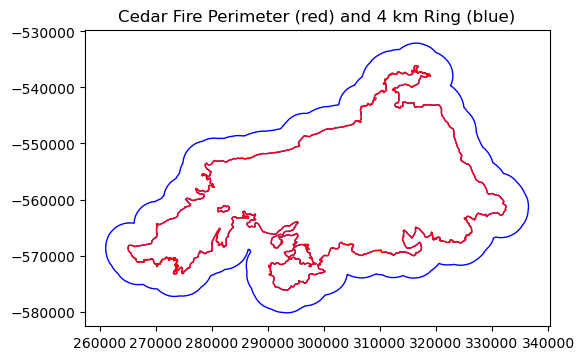

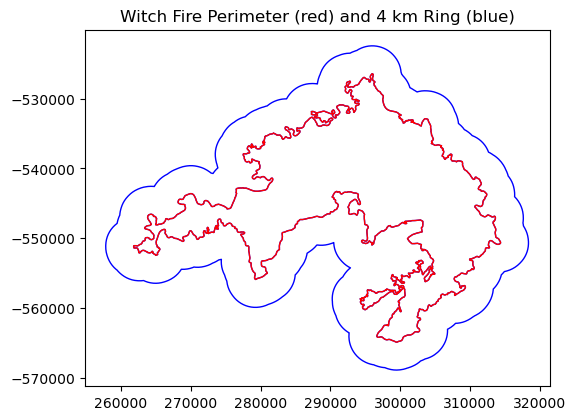

In [4]:
# --- Cedar ---
fig, ax = plt.subplots(figsize=(6, 6))
cedar_ring_gdf.plot(ax=ax, edgecolor='blue', facecolor='none', linewidth=1)
cedar_fire_gdf.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=1)

ax.set_title("Cedar Fire Perimeter (red) and 4 km Ring (blue)")
plt.show()

fig.savefig(FIG_DIR / "cedar_fire_shrub_buffer.png", dpi=300, bbox_inches="tight")


# --- Witch ---
fig, ax = plt.subplots(figsize=(6, 6))
witch_ring_gdf.plot(ax=ax, edgecolor='blue', facecolor='none', linewidth=1)
witch_fire_gdf.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=1)

ax.set_title("Witch Fire Perimeter (red) and 4 km Ring (blue)")
plt.show()

fig.savefig(FIG_DIR / "witch_fire_shrub_buffer.png", dpi=300, bbox_inches="tight")

### Step 3: Clip the raster 
So because of how we need to clip years, we are going to have to create a new helper function for this. With the function we will call each set of years we want for cedar and witch. For each fire we will follow the same process, with cedar first. We will then have a cedar_shrub_df and a witch_shrub_df where we have labeled the columns, fire, year, region, mean_shrub, and n_pixels.

In [5]:
import rasterio
import rasterio.mask
from shapely.geometry import mapping

def get_region_values_for_year(year, year_files_dict, region_geom, region_crs):
    """
    For a given year and a region geometry (fire or ring),
    read only the intersecting part of the RCMAP tile(s) from disk
    and return a 1D array of valid pixel values.
    """
    tif_paths = year_files_dict.get(year, [])
    if not tif_paths:
        return np.array([])

    vals_list = []

    for tif_path in tif_paths:
        with rasterio.open(tif_path) as src:
            # Transform region geometry into raster CRS
            geom_in_raster_crs = (
                gpd.GeoSeries([region_geom], crs=region_crs)
                .to_crs(src.crs)
                .iloc[0]
            )

            # Mask reads only intersecting window from disk
            out_image, out_transform = rasterio.mask.mask(
                src,
                [mapping(geom_in_raster_crs)],
                crop=True,
                filled=True
            )

            data = out_image[0]  # band 1
            vals_list.append(data[np.isfinite(data)])

    if not vals_list:
        return np.array([])

    return np.concatenate(vals_list)

Since we need to clip to years that we want, call the CEDAR_YEARS and WITCH_YEARS. Originally WITCH_YEARS last post-fire year was 2020. In this part of the notebook we will expand it to 2024, so each fire has a similar number of years compared Cedar (2000-2020-20 years) and Witch (2004-2024-20 years)

In [6]:
print(CEDAR_YEARS)
print(WITCH_YEARS)

{'pre_fire': [2000, 2001, 2002], 'fire_year': [2003], 'post_fire': [2004, 2005, 2010, 2015, 2020]}
{'pre_fire': [2004, 2005, 2006], 'fire_year': [2007], 'post_fire': [2008, 2010, 2015, 2020]}


In the next code cell we will trim the number of years we are calling so we don't overburden RAM. For Cedar, these are the same years we used to make our year(%) land cover change map of 6 plots. 

In [7]:
CEDAR_YEARS_USE = [2000, 2003, 2005, 2010, 2015, 2020]  

cedar_results = []

for year in CEDAR_YEARS_USE:
    cedar_inside_vals = get_region_values_for_year(
        year,
        RCMAP_YEAR_FILES,
        region_geom=cedar_geom,      # burned area
        region_crs=cedar_3310.crs
    )

    cedar_ring_vals = get_region_values_for_year(
        year,
        RCMAP_YEAR_FILES,
        region_geom=cedar_ring_geom, # 0–4 km ring
        region_crs=cedar_3310.crs
    )

    cedar_results.append({
        "fire": "Cedar",
        "year": year,
        "region": "inside",
        "mean_shrub": float(np.nanmean(cedar_inside_vals)) if cedar_inside_vals.size else np.nan,
        "n_pixels": int(cedar_inside_vals.size),
    })
    cedar_results.append({
        "fire": "Cedar",
        "year": year,
        "region": "ring",
        "mean_shrub": float(np.nanmean(cedar_ring_vals)) if cedar_ring_vals.size else np.nan,
        "n_pixels": int(cedar_ring_vals.size),
    })

cedar_results_df = pd.DataFrame(cedar_results)
cedar_results_df

,fire,year,region,mean_shrub,n_pixels
0,Cedar,2000,inside,75.653328,2481990
1,Cedar,2000,ring,89.223790,3443670
2,Cedar,2003,inside,63.741252,2481990
3,Cedar,2003,ring,87.869259,3443670
4,Cedar,2005,inside,65.797322,2481990
5,Cedar,2005,ring,88.464922,3443670
6,Cedar,2010,inside,71.766679,2481990
7,Cedar,2010,ring,88.612543,3443670
8,Cedar,2015,inside,74.881617,2481990
9,Cedar,2015,ring,89.414653,3443670


Now we do the same thing for witch, using the same years from the map we plotted in the previous notebook. This time, we will expand out to 2024, since that gives the same number of years for recovery as the cedar (post fire-17 years) and witch (post fire (2007 to 2024) -17 years). We will still keep the 2000 year for witch so we will have 7 instead of 6 maps. The reason for this is because in 2004 we can already see that re-burned area, so we want a true pre-fire plot still to compare with. Go back to the witch_fire_landcover_change if you need a refresher between the witch 2000 and witch 2004 maps. 

In [8]:
WITCH_YEARS_USE = [2000, 2004, 2007, 2010, 2015, 2020, 2024]  

witch_results = []

for year in WITCH_YEARS_USE:
    witch_inside_vals = get_region_values_for_year(
        year,
        RCMAP_YEAR_FILES,
        region_geom=witch_geom,
        region_crs=witch_3310.crs
    )

    witch_ring_vals = get_region_values_for_year(
        year,
        RCMAP_YEAR_FILES,
        region_geom=witch_ring_geom,
        region_crs=witch_3310.crs
    )

    witch_results.append({
        "fire": "Witch",
        "year": year,
        "region": "inside",
        "mean_shrub": float(np.nanmean(witch_inside_vals)) if witch_inside_vals.size else np.nan,
        "n_pixels": int(witch_inside_vals.size),
    })
    witch_results.append({
        "fire": "Witch",
        "year": year,
        "region": "ring",
        "mean_shrub": float(np.nanmean(witch_ring_vals)) if witch_ring_vals.size else np.nan,
        "n_pixels": int(witch_ring_vals.size),
    })

witch_results_df = pd.DataFrame(witch_results)
witch_results_df


,fire,year,region,mean_shrub,n_pixels
0,Witch,2000,inside,82.576755,2170880
1,Witch,2000,ring,86.601514,3034080
2,Witch,2004,inside,79.871226,2170880
3,Witch,2004,ring,82.315522,3034080
4,Witch,2007,inside,76.223116,2170880
5,Witch,2007,ring,84.986726,3034080
6,Witch,2010,inside,79.063469,2170880
7,Witch,2010,ring,85.704793,3034080
8,Witch,2015,inside,80.899168,2170880
9,Witch,2015,ring,86.675919,3034080


### Step 4: Pivot tables
Lets look at the differences for each fire and their inside outside values before plotting. We will make a cedar pivot and witch pivot table. 

In [ ]:
# Pivot
cedar_pivot = (
    cedar_results_df
    .pivot(index="year", columns="region", values="mean_shrub")
    .reset_index()
)

# Compute contrast (ring - inside)
cedar_pivot["diff_ring_minus_inside"] = (
    cedar_pivot["ring"] - cedar_pivot["inside"]
)

cedar_pivot


region,year,inside,ring,diff_ring_minus_inside
0,2000,75.653328,89.223790,13.570462
1,2003,63.741252,87.869259,24.128006
2,2005,65.797322,88.464922,22.667600
3,2010,71.766679,88.612543,16.845864
4,2015,74.881617,89.414653,14.533036
5,2020,77.154858,90.272823,13.117965


In [ ]:
# Pivot 
witch_pivot = (
    witch_results_df
    .pivot(index="year", columns="region", values="mean_shrub")
    .reset_index()
)

witch_pivot["diff_ring_minus_inside"] = (
    witch_pivot["ring"] - witch_pivot["inside"]
)

witch_pivot

region,year,inside,ring,diff_ring_minus_inside
0,2000,82.576755,86.601514,4.024759
1,2004,79.871226,82.315522,2.444296
2,2007,76.223116,84.986726,8.763610
3,2010,79.063469,85.704793,6.641324
4,2015,80.899168,86.675919,5.776751
5,2020,82.701363,87.697582,4.996220
6,2024,83.138845,87.630474,4.491630


### Step 5: Plot
Now we can plot the recovery patterns for both cedar and witch to visualize these differences inside and outside the fire perimeters. Here we will plot some simple figures first with lines for inside and outside each fire, and then a difference plot. Once we have these we will visualize the shrub cover change both inside and outside the fires. 

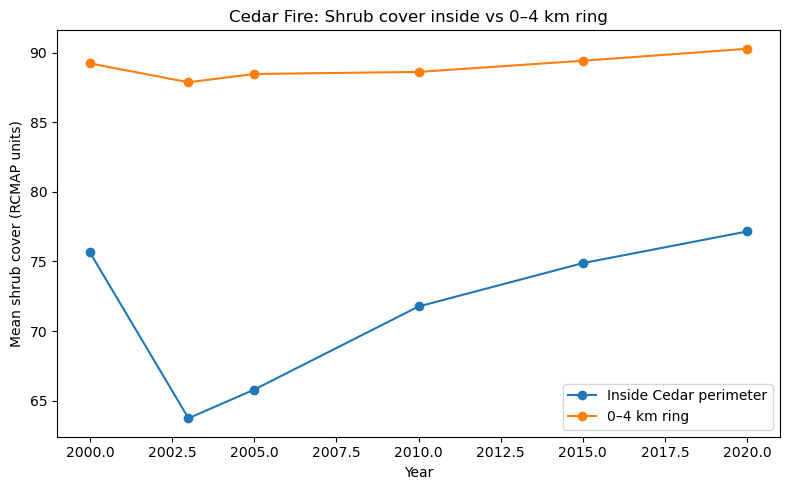

<Figure size 640x480 with 0 Axes>

In [11]:
# Plot inside v. ring over time for cedar
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))

plt.plot(cedar_pivot["year"], cedar_pivot["inside"], marker="o", label="Inside Cedar perimeter")
plt.plot(cedar_pivot["year"], cedar_pivot["ring"],   marker="o", label="0–4 km ring")

plt.xlabel("Year")
plt.ylabel("Mean shrub cover (RCMAP units)")
plt.title("Cedar Fire: Shrub cover inside vs 0–4 km ring")
plt.legend()
plt.tight_layout()
plt.show()

# Save
plt.gcf().savefig(FIG_DIR / "cedar_inside_vs_ring_timeseries.png", dpi=300, bbox_inches="tight")

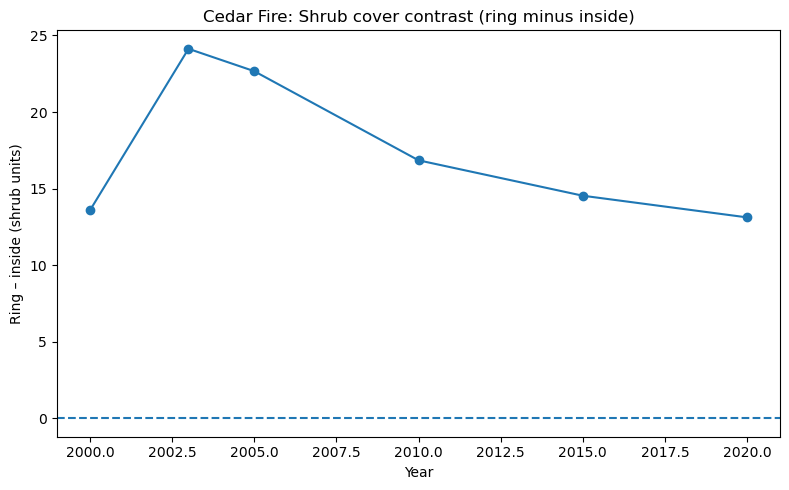

<Figure size 640x480 with 0 Axes>

In [12]:
# Cedar minus
plt.figure(figsize=(8,5))
plt.plot(
    cedar_pivot["year"],
    cedar_pivot["diff_ring_minus_inside"],
    marker="o"
)
plt.axhline(0, linestyle="--")

plt.xlabel("Year")
plt.ylabel("Ring – inside (shrub units)")
plt.title("Cedar Fire: Shrub cover contrast (ring minus inside)")
plt.tight_layout()
plt.show()

# Save
plt.gcf().savefig(FIG_DIR / "cedar_minus_ring_timeseries.png", dpi=300, bbox_inches="tight")

### What do these plots tell us? 

Here we are comparing unburned nearby shrublands (0–4 km buffer) to burned interior shrublands. If our values are positive (ring > inside), the surrounding landscape is shrubbier, meaning that 1) the fire interior has lower shrub cover (due to fire impact) and 2) the area outside the fire perimeter is functioning as a “healthy baseline” in terms of shrub cover.

### Shrub cover inside the Cedar Fire perimeter (2003 burn) shows a dramatic post-fire decline relative to nearby unburned areas.

In 2000, mean shrub cover inside the fire area was ~76 compared to ~89 in the 0–4 km ring — a moderate difference of ~13 units. By 2003, the burn year, interior shrub cover dropped to ~64 while the ring remained stable at ~88, yielding a sharp contrast of ~24 units.

Partial recovery is evident by 2010 (inside ~72), and by 2020 interior shrub cover reaches ~77. However, the unburned ring also remains high (~90), and the inside–outside gap persists across all years (~13–16 units in 2010–2020).

In short, Cedar Fire shrublands experience a severe loss in the burn year and show long-term recovery, but the interior landscape remains consistently less shrub-dense than surrounding unburned areas even 17 years after the fire.

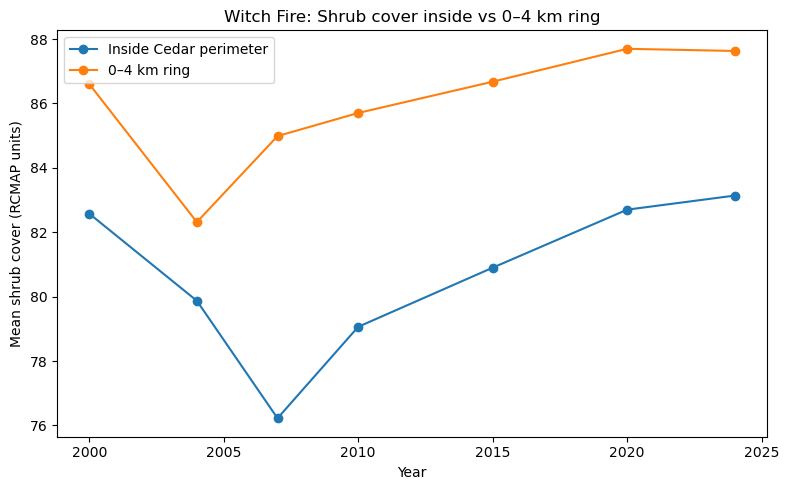

<Figure size 640x480 with 0 Axes>

In [13]:
# Plot inside v. ring over time for witch
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))

plt.plot(witch_pivot["year"], witch_pivot["inside"], marker="o", label="Inside Cedar perimeter")
plt.plot(witch_pivot["year"], witch_pivot["ring"],   marker="o", label="0–4 km ring")

plt.xlabel("Year")
plt.ylabel("Mean shrub cover (RCMAP units)")
plt.title("Witch Fire: Shrub cover inside vs 0–4 km ring")
plt.legend()
plt.tight_layout()
plt.show()

# Save
plt.gcf().savefig(FIG_DIR / "witch_inside_vs_ring_timeseries.png", dpi=300, bbox_inches="tight")

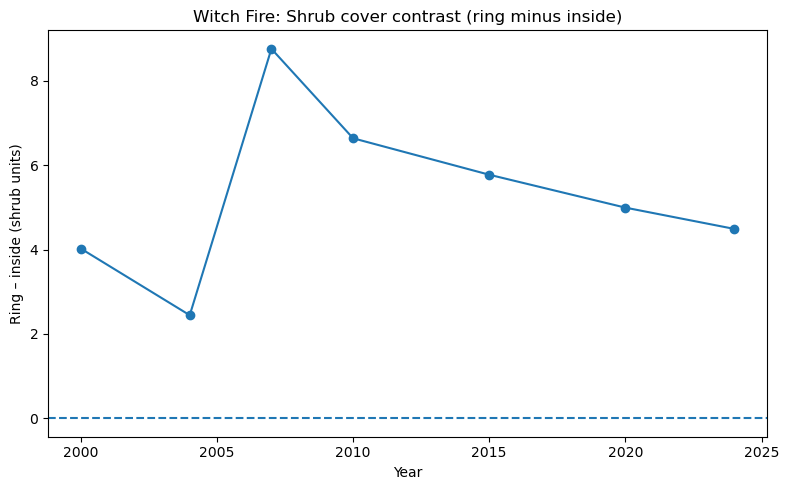

<Figure size 640x480 with 0 Axes>

In [14]:
# Witch minus
plt.figure(figsize=(8,5))
plt.plot(
    witch_pivot["year"],
    witch_pivot["diff_ring_minus_inside"],
    marker="o"
)
plt.axhline(0, linestyle="--")

plt.xlabel("Year")
plt.ylabel("Ring – inside (shrub units)")
plt.title("Witch Fire: Shrub cover contrast (ring minus inside)")
plt.tight_layout()
plt.show()

# Save
plt.gcf().savefig(FIG_DIR / "witch_minus_ring_timeseries.png", dpi=300, bbox_inches="tight")

### The Witch Fire interior exhibits a compound disturbance trajectory:
shrub cover declines in 2003 due to the Cedar Fire, then declines again more sharply in 2007 during the Witch Fire reburn.
Outside the fire perimeter, the 0–4 km ring shows a modest decrease in 2003 (likely reflecting proximity effects or partial overlap with Cedar) but recovers steadily thereafter, with no decline in 2007 because the ring was largely unburned by Witch.

This produces a widening divergence between burned and unburned shrublands after 2007, with the ring consistently maintaining higher shrub cover as interior shrublands recover from repeated high-severity fires.

### What “Ring – Inside” Values Means

For every measured year, the unburned nearby landscape (0–4 km ring) has higher shrub cover than the burned area for both fires.

For both the Cedar and Witch fires, all contrast values (ring minus inside) are positive, indicating that shrub cover in the 0–4 km unburned buffer remains higher than inside the fire perimeter across all years. This pattern reflects expected post-fire vegetation dynamics: burned shrublands exhibit substantial short-term loss in cover, followed by gradual recovery, while unburned nearby areas provide a stable reference level.

### This is ecologically expected because:

- Fire reduces shrub cover sharply
- Recovery takes years to decades
- Surrounding areas act as a reference benchmark for unaffected vegetation

### For the 2007 Witch Fire we have approximately: 
| Year | Ring – Inside |
| ---- | ------------- |
| 2000 | ~4            |
| 2004 | ~2.4          |
| 2007 | ~8.8          |
| 2010 | ~6.6          |
| 2015 | ~5.8          |
| 2020 | ~5.0          |
| 2024 | ~4.5          |

#### What this shows:
Before 2007:
- The fire interior already had lower shrub cover because Witch partially overlaps the Cedar 2003 burn.
- The contrast increases gradually as the Cedar footprint recovers slowly.

Sharp peak in 2007:
- Witch Fire re-burns the interior, so shrub cover drops markedly, leading to a contrast dip.

After 2007:
- The interior recovers but remains consistently below ring levels by ~4–6 shrub units.
- This is a signature of compound disturbance (reburned chaparral recovers more slowly).

### For the 2003 Cedar Fire we have approximately:
| Year | Ring – Inside |
| ---- | ------------- |
| 2000 | ~13.6         |
| 2003 | ~24.1         |
| 2005 | ~22.7         |
| 2010 | ~16.8         |
| 2015 | ~14.5         |
| 2020 | ~13.1         |

#### What this shows: 
Before burn (2000):
- Already a substantial difference (~13 units), meaning the Cedar interior likely had some combination of the following that is beyond the scope of this notebook/project:
    - more dense chaparral pre-burn, or
    - more topographic variation, or
    - different pre-fire structure than the surrounding ring.

Huge spike in 2003–2005:
- The Cedar Fire caused a massive loss of shrub cover. This was much more severe than Witch’s relative effect.
- Inside dropped ~12 points, ring remained near 89.
- This creates a contrast of ~24 units in 2003 which is extremely large.

Long-term recovery:
- Even by 2020 (17 years post-fire):
    - the interior is still ~13 units below the ring
    - shrub recovery is evident but the inside perimeter is still less dense than the 0-4km area
    - as a result, Cedar appears to have produced longer-term ecological change

In [ ]:
# Now lets plot the pivots of these fires together to just help with comparison
# Don't need to save this figure
both_fires_df = pd.concat([cedar_results_df, witch_results_df], ignore_index=True)

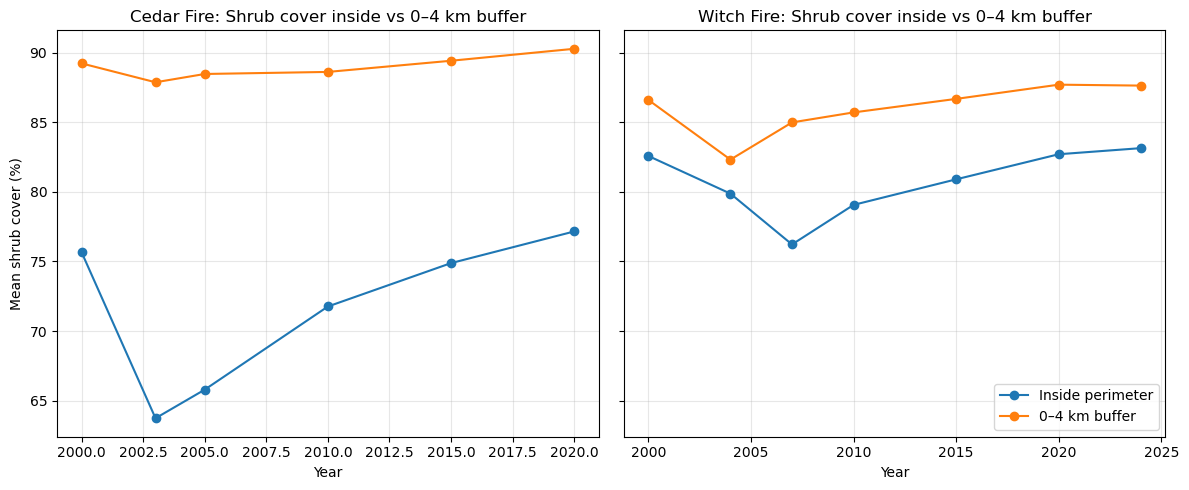

In [16]:
# Side by side plot
fires = ["Cedar", "Witch"]

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

for ax, fire in zip(axes, fires):
    df_fire = (both_fires_df[both_fires_df["fire"] == fire]
               .pivot(index="year", columns="region", values="mean_shrub")
               .sort_index())

    # Lines for inside and 0–4 km ring
    ax.plot(df_fire.index, df_fire["inside"], marker="o", label="Inside perimeter")
    ax.plot(df_fire.index, df_fire["ring"],   marker="o", label="0–4 km buffer")

    ax.set_title(f"{fire} Fire: Shrub cover inside vs 0–4 km buffer")
    ax.set_xlabel("Year")
    ax.grid(True, alpha=0.3)

axes[0].set_ylabel("Mean shrub cover (%)")  # shared y-axis label
axes[1].legend(loc="lower right")

fig.tight_layout()
plt.show()

### Step 5.1: Plot the shrub cover maps using the inside and outside geoms and gdfs
Here we will use the polygons and gdfs we created at the start of the notebook.

In [17]:
import rasterio
from rasterio import mask
import numpy as np

def load_and_clip_rcmap_year(year, boundary_gdf):
    """
    Load the RCMAP shrub raster for a given year and clip it to the given boundary.

    Parameters
    ----------
    year : int
    boundary_gdf : GeoDataFrame
        GeoDataFrame with the polygon(s) to clip to (e.g., fire perimeter or buffer).

    Returns
    -------
    band : 2D numpy array (float32)
        Shrub cover (%), with NaNs where nodata or out-of-range.
    transform : affine.Affine
        Transform for the clipped raster.
    meta : dict
        Raster metadata (including updated transform, width, height, crs).
    """
    tif_list = RCMAP_YEAR_FILES.get(year)
    if not tif_list:
        raise ValueError(f"No RCMAP rasters found for year {year}")

    # In your setup there is 1 file per year
    tif_path = tif_list[0]
    print(f"\n=== Loading RCMAP shrub for {year} ===")
    print(f"Using file: {tif_path}")

    with rasterio.open(tif_path) as src:
        print("RCMAP CRS:", src.crs)
        print("RCMAP bounds:", src.bounds)
        print("RCMAP nodata:", src.nodata)

        # Reproject boundary to raster CRS
        boundary_in_raster_crs = boundary_gdf.to_crs(src.crs)

        # Clip raster to boundary
        out_img, out_transform = mask.mask(
            src,
            boundary_in_raster_crs.geometry,
            crop=True
        )
        out_meta = src.meta.copy()

    data = out_img.astype("float32")
    nodata = out_meta.get("nodata", None)

    band = data[0]

    # Replace nodata with NaN
    if nodata is not None:
        band[band == nodata] = np.nan

    # Enforce valid shrub % range (same as before)
    band[band < 0] = np.nan
    band[band > 100] = np.nan

    # Update meta
    out_meta.update({
        "height": band.shape[0],
        "width": band.shape[1],
        "transform": out_transform
    })

    # Optional debug
    print("Clipped array shape (rows, cols):", band.shape)
    if np.isnan(band).all():
        print("All values are NaN after clipping — no overlapping pixels?")
    else:
        print("Min shrub %:", np.nanmin(band))
        print("Max shrub %:", np.nanmax(band))

    return band, out_transform, out_meta


In [18]:
# GeoDataFrames for the 0–4 km buffers
witch_buffer_gdf = gpd.GeoDataFrame(geometry=[witch_buffer_geom], crs=witch_3310.crs)
cedar_buffer_gdf = gpd.GeoDataFrame(geometry=[cedar_buffer_geom], crs=cedar_3310.crs)



=== Loading RCMAP shrub for 2000 ===
Using file: C:\Users\kayle\Desktop\earth-analytics\Final project\ramona-fire-recovery\data\raw\landcover\rcmap_shrub\Shrub_1998_2010\rcmap_shrub_2000.tif
RCMAP CRS: EPSG:5070
RCMAP bounds: BoundingBox(left=-2875426.1657657186, bottom=309855.9458113904, right=592483.8342342814, top=3290175.9458113904)
RCMAP nodata: 101.0
Clipped array shape (rows, cols): (1548, 1960)
Min shrub %: 0.0
Max shrub %: 96.0

=== Loading RCMAP shrub for 2004 ===
Using file: C:\Users\kayle\Desktop\earth-analytics\Final project\ramona-fire-recovery\data\raw\landcover\rcmap_shrub\Shrub_1998_2010\rcmap_shrub_2004.tif
RCMAP CRS: EPSG:5070
RCMAP bounds: BoundingBox(left=-2875426.1657657186, bottom=309855.9458113904, right=592483.8342342814, top=3290175.9458113904)
RCMAP nodata: 101.0
Clipped array shape (rows, cols): (1548, 1960)
Min shrub %: 0.0
Max shrub %: 93.0

=== Loading RCMAP shrub for 2007 ===
Using file: C:\Users\kayle\Desktop\earth-analytics\Final project\ramona-fire-r

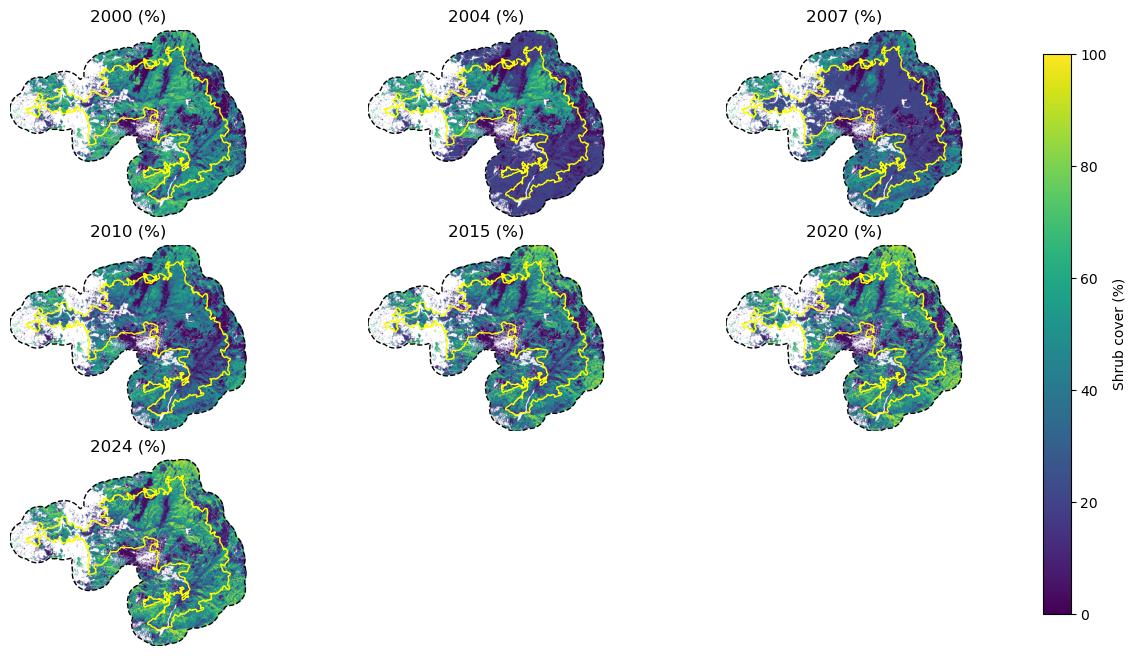

In [19]:
# Witch % inside and buffer mapping
# ===========================================================
# Witch Fire shrub % maps WITH 0–4 km buffer
# ===========================================================

witch_years_to_plot = [2000, 2004, 2007, 2010, 2015, 2020, 2024]

nrows, ncols = 3, 3
fig, axes = plt.subplots(nrows, ncols, figsize=(14, 8))
axes_flat = axes.ravel()

for ax, year in zip(axes_flat, witch_years_to_plot):
    band, transform, meta = load_and_clip_rcmap_year(
        year,
        witch_buffer_gdf   # buffer GDF, not the perimeter
    )

    nrows_band, ncols_band = band.shape
    left = transform.c
    top = transform.f
    right = left + transform.a * ncols_band
    bottom = top + transform.e * nrows_band

    # Colormap: NaNs (nodata + out-of-range) will be white
    cmap = plt.cm.viridis.copy()
    cmap.set_bad(color="white")

    im = ax.imshow(
        band,
        vmin=0,
        vmax=100,
        cmap=cmap,
        extent=(left, right, bottom, top),
        origin="upper",
    )

    # Plot Witch perimeter in white
    witch_fire_gdf.to_crs(meta["crs"]).boundary.plot(
        ax=ax,
        color="yellow",
        linewidth=1,
    )

    # Plot 0–4 km buffer boundary (dashed)
    witch_buffer_gdf.to_crs(meta["crs"]).boundary.plot(
        ax=ax,
        color="black",
        linestyle="--",
        linewidth=1,
    )

    ax.set_title(f"{year} (%)")
    ax.set_axis_off()

for ax in axes_flat[len(witch_years_to_plot):]:
    ax.set_visible(False)

fig.subplots_adjust(right=0.88, wspace=0.05, hspace=0.15)
cbar_ax = fig.add_axes([0.90, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label("Shrub cover (%)")

plt.show()

fig.savefig(FIG_DIR / "witch_shrub_buffer_percent_maps.png", dpi=300, bbox_inches="tight")

### What is this white stuff? 
These white areas are NaN values for shrub cover. However, if you remember back to our Ramona CDP boundary, you will notice that all of these white areas are actually urban or built environments (In the center of the map you can see Ramona as a small white pocket wi with the county estates just east of it in the buffer zone). So there is no shrub here due to human settlements. The same applies to the white we see in the eastern part of the buffer area. There is a step elevation drop between Ramona and San Diego County. What we see here are portions of the City of Poway (east) and City of Escondido (north east).


=== Loading RCMAP shrub for 2000 ===
Using file: C:\Users\kayle\Desktop\earth-analytics\Final project\ramona-fire-recovery\data\raw\landcover\rcmap_shrub\Shrub_1998_2010\rcmap_shrub_2000.tif
RCMAP CRS: EPSG:5070
RCMAP bounds: BoundingBox(left=-2875426.1657657186, bottom=309855.9458113904, right=592483.8342342814, top=3290175.9458113904)
RCMAP nodata: 101.0
Clipped array shape (rows, cols): (1383, 2490)
Min shrub %: 0.0
Max shrub %: 95.0

=== Loading RCMAP shrub for 2003 ===
Using file: C:\Users\kayle\Desktop\earth-analytics\Final project\ramona-fire-recovery\data\raw\landcover\rcmap_shrub\Shrub_1998_2010\rcmap_shrub_2003.tif
RCMAP CRS: EPSG:5070
RCMAP bounds: BoundingBox(left=-2875426.1657657186, bottom=309855.9458113904, right=592483.8342342814, top=3290175.9458113904)
RCMAP nodata: 101.0
Clipped array shape (rows, cols): (1383, 2490)
Min shrub %: 0.0
Max shrub %: 92.0

=== Loading RCMAP shrub for 2005 ===
Using file: C:\Users\kayle\Desktop\earth-analytics\Final project\ramona-fire-r

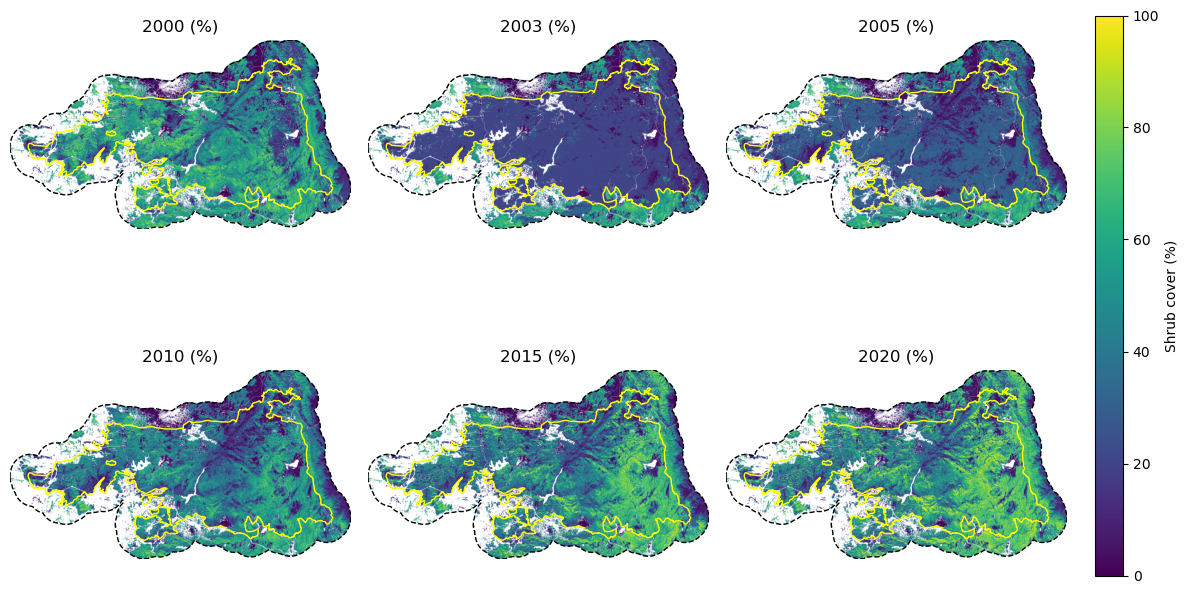

In [ ]:
# Same process but for cedar
# ===========================================================
# Cedar Fire shrub % maps WITH 0–4 km buffer
# ===========================================================

cedar_years_to_plot = [2000, 2003, 2005, 2010, 2015, 2020]  # adjust as needed

nrows, ncols = 2, 3
fig, axes = plt.subplots(nrows, ncols, figsize=(14, 8))
axes_flat = axes.ravel()

for ax, year in zip(axes_flat, cedar_years_to_plot):
    band, transform, meta = load_and_clip_rcmap_year(
        year,
        cedar_buffer_gdf   # buffer GDF, not the perimeter
    )

    nrows_band, ncols_band = band.shape
    left = transform.c
    top = transform.f
    right = left + transform.a * ncols_band
    bottom = top + transform.e * nrows_band

    # Colormap: NaNs (nodata + out-of-range) will be white
    cmap = plt.cm.viridis.copy()
    cmap.set_bad(color="white")

    im = ax.imshow(
        band,
        vmin=0,
        vmax=100,
        cmap=cmap,
        extent=(left, right, bottom, top),
        origin="upper",
    )

    # Plot Witch perimeter in white
    cedar_fire_gdf.to_crs(meta["crs"]).boundary.plot(
        ax=ax,
        color="yellow",
        linewidth=1,
    )

    # Plot 0–4 km buffer boundary (dashed)
    cedar_buffer_gdf.to_crs(meta["crs"]).boundary.plot(
        ax=ax,
        color="black",
        linestyle="--",
        linewidth=1,
    )

    ax.set_title(f"{year} (%)")
    ax.set_axis_off()

for ax in axes_flat[len(cedar_years_to_plot):]:
    ax.set_visible(False)

fig.subplots_adjust(right=0.88, wspace=0.05, hspace=0.15)
cbar_ax = fig.add_axes([0.90, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label("Shrub cover (%)")

plt.show()

fig.savefig(FIG_DIR / "cedar_shrub_buffer_percent_maps.png", dpi=300, bbox_inches="tight")

### Other urban areas
As the Cedar Fire burned far more south of Ramona, here we still are seeing some parts of Poway, but to the South we are seeing the city of Lakeside. 

### Step 6: Store variables

In [21]:
# Geometry/gdfs
%store cedar_fire_gdf witch_fire_gdf cedar_ring_gdf witch_ring_gdf cedar_buffer_gdf witch_buffer_gdf


Stored 'cedar_fire_gdf' (GeoDataFrame)
Stored 'witch_fire_gdf' (GeoDataFrame)
Stored 'cedar_ring_gdf' (GeoDataFrame)
Stored 'witch_ring_gdf' (GeoDataFrame)
Stored 'cedar_buffer_gdf' (GeoDataFrame)
Stored 'witch_buffer_gdf' (GeoDataFrame)
